### 1- Create an SQL query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features

In [1]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import getpass
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
password = getpass.getpass()

········


In [6]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/bank'
engine = create_engine(connection_string)
query = '''
create or replace view sakila.regression_model_data as
with cte_1 as (
select f.film_id, f.release_year, l.name as language, r.quantity, f.rental_rate as price, f.length, f.rating, c.name as category
from sakila.film f
left join film_category fc on f.film_id = fc.film_id
left join category c on fc.category_id = c.category_id
left join language l on f.language_id = l.language_id
left join nb_film_rented r on r.film_id = f.film_id
order by quantity desc)
select * from sakila.regression_model_data;
'''

In [8]:
query_2 = '''
select * from sakila.regression_model_data;
'''
data = pd.read_sql_query(query_2, engine)
data


,film_id,release_year,language,quantity,price,length,rating,category
0,103,2006,English,34.0,4.99,133,PG,Travel
1,738,2006,English,33.0,0.99,178,PG-13,Foreign
2,331,2006,English,32.0,2.99,90,NC-17,Games
3,382,2006,English,32.0,0.99,137,PG,Games
4,489,2006,English,32.0,0.99,54,PG-13,Animation
...,...,...,...,...,...,...,...,...
995,909,2006,English,NaN,0.99,102,PG-13,Horror
996,943,2006,English,NaN,4.99,76,PG-13,Documentary
997,950,2006,English,NaN,4.99,132,PG,Classics
998,954,2006,English,NaN,4.99,73,G,New


### 2- Read the data into a Pandas dataframe

In [9]:
data

,film_id,release_year,language,quantity,price,length,rating,category
0,103,2006,English,34.0,4.99,133,PG,Travel
1,738,2006,English,33.0,0.99,178,PG-13,Foreign
2,331,2006,English,32.0,2.99,90,NC-17,Games
3,382,2006,English,32.0,0.99,137,PG,Games
4,489,2006,English,32.0,0.99,54,PG-13,Animation
...,...,...,...,...,...,...,...,...
995,909,2006,English,NaN,0.99,102,PG-13,Horror
996,943,2006,English,NaN,4.99,76,PG-13,Documentary
997,950,2006,English,NaN,4.99,132,PG,Classics
998,954,2006,English,NaN,4.99,73,G,New


### 3- Analyze extracted features and transform them. You may need to encode some categorical variables, or scale numerical variables

In [11]:
data.set_index('film_id')

,release_year,language,quantity,price,length,rating,category
film_id,,,,,,,
103,2006,English,34.0,4.99,133,PG,Travel
738,2006,English,33.0,0.99,178,PG-13,Foreign
331,2006,English,32.0,2.99,90,NC-17,Games
382,2006,English,32.0,0.99,137,PG,Games
489,2006,English,32.0,0.99,54,PG-13,Animation
...,...,...,...,...,...,...,...
909,2006,English,NaN,0.99,102,PG-13,Horror
943,2006,English,NaN,4.99,76,PG-13,Documentary
950,2006,English,NaN,4.99,132,PG,Classics


In [12]:
data.dtypes

film_id           int64
release_year      int64
language         object
quantity        float64
price           float64
length            int64
rating           object
category         object
dtype: object

In [13]:
data.isna().sum()

film_id          0
release_year     0
language         0
quantity        42
price            0
length           0
rating           0
category         0
dtype: int64

In [14]:
data=data.dropna()
data # dropping films that were never rented (quantity = 0)

,film_id,release_year,language,quantity,price,length,rating,category
0,103,2006,English,34.0,4.99,133,PG,Travel
1,738,2006,English,33.0,0.99,178,PG-13,Foreign
2,331,2006,English,32.0,2.99,90,NC-17,Games
3,382,2006,English,32.0,0.99,137,PG,Games
4,489,2006,English,32.0,0.99,54,PG-13,Animation
...,...,...,...,...,...,...,...,...
953,781,2006,English,5.0,4.99,127,R,Games
954,903,2006,English,5.0,4.99,139,G,Travel
955,400,2006,English,4.0,2.99,72,R,Documentary
956,584,2006,English,4.0,2.99,180,PG-13,Foreign


In [26]:
data['length'] = data['length'].astype('object') # treating duration as categorical
data['release_year'] = data['release_year'].astype('object') # treating duration as categorical
data['film_id'] = data['film_id'].astype('int64') # treating duration as categorical

data

<ipython-input-26-5cef4a843d8d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['length'] = data['length'].astype('object') # treating duration as categorical
<ipython-input-26-5cef4a843d8d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['release_year'] = data['release_year'].astype('object') # treating duration as categorical
<ipython-input-26-5cef4a843d8d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

,film_id,release_year,language,quantity,price,length,rating,category
0,103,2006,English,34.0,4.99,133,PG,Travel
1,738,2006,English,33.0,0.99,178,PG-13,Foreign
2,331,2006,English,32.0,2.99,90,NC-17,Games
3,382,2006,English,32.0,0.99,137,PG,Games
4,489,2006,English,32.0,0.99,54,PG-13,Animation
...,...,...,...,...,...,...,...,...
953,781,2006,English,5.0,4.99,127,R,Games
954,903,2006,English,5.0,4.99,139,G,Travel
955,400,2006,English,4.0,2.99,72,R,Documentary
956,584,2006,English,4.0,2.99,180,PG-13,Foreign


In [28]:
data.dtypes

film_id           int64
release_year     object
language         object
quantity        float64
price           float64
length           object
rating           object
category         object
dtype: object

In [29]:
df = pd.get_dummies(data, drop_first=True) # i'm lazy
df

,film_id,quantity,price,length_47,length_48,length_49,length_50,length_51,length_52,length_53,...,category_Drama,category_Family,category_Foreign,category_Games,category_Horror,category_Music,category_New,category_Sci-Fi,category_Sports,category_Travel
0,103,34.0,4.99,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,738,33.0,0.99,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,331,32.0,2.99,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,382,32.0,0.99,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,489,32.0,0.99,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
953,781,5.0,4.99,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
954,903,5.0,4.99,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
955,400,4.0,2.99,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
956,584,4.0,2.99,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [35]:
df['film_id'] = df['film_id'].astype('object') # treating duration as categorical
df

,film_id,quantity,price,length_47,length_48,length_49,length_50,length_51,length_52,length_53,...,category_Drama,category_Family,category_Foreign,category_Games,category_Horror,category_Music,category_New,category_Sci-Fi,category_Sports,category_Travel
0,103,34.0,4.99,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,738,33.0,0.99,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,331,32.0,2.99,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,382,32.0,0.99,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,489,32.0,0.99,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
953,781,5.0,4.99,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
954,903,5.0,4.99,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
955,400,4.0,2.99,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
956,584,4.0,2.99,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [37]:
df.set_index('film_id')
df

,film_id,quantity,price,length_47,length_48,length_49,length_50,length_51,length_52,length_53,...,category_Drama,category_Family,category_Foreign,category_Games,category_Horror,category_Music,category_New,category_Sci-Fi,category_Sports,category_Travel
0,103,34.0,4.99,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,738,33.0,0.99,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,331,32.0,2.99,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,382,32.0,0.99,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,489,32.0,0.99,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
953,781,5.0,4.99,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
954,903,5.0,4.99,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
955,400,4.0,2.99,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
956,584,4.0,2.99,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


### 4- Create a query to get the list of films and a boolean indicating if it was rented last month. This would be our target variable

In [53]:
query_3 = '''
create or replace view sakila.rented_last_month as
select distinct(film_id),
case
when film_id in
(select film_id from sakila.monthly_film
where rental_month = 2 and rental_year = 2006) then true
else false
end as rented_last_month
from film;
'''

In [54]:
query_4='''
select * from sakila.rented_last_month;
'''

In [59]:
query_5='''
select m.film_id, m.release_year, m.language, m.quantity, m.price, m.length, m.rating, m.category, r.rented_last_month
from sakila.regression_model_data m
left join sakila.rented_last_month r on m.film_id=r.film_id
order by rented_last_month desc, quantity desc;
'''

In [61]:
df2 = pd.read_sql_query(query_5, engine)
df2

,film_id,release_year,language,quantity,price,length,rating,category,rented_last_month
0,489,2006,English,32.0,0.99,54,PG-13,Animation,1
1,730,2006,English,32.0,0.99,46,PG-13,New,1
2,127,2006,English,30.0,4.99,112,G,Comedy,1
3,341,2006,English,30.0,0.99,82,PG,Classics,1
4,403,2006,English,30.0,4.99,121,PG-13,Drama,1
...,...,...,...,...,...,...,...,...,...
995,909,2006,English,NaN,0.99,102,PG-13,Horror,0
996,943,2006,English,NaN,4.99,76,PG-13,Documentary,0
997,950,2006,English,NaN,4.99,132,PG,Classics,0
998,954,2006,English,NaN,4.99,73,G,New,0


### 5- Create a logistic regression model to predict this variable from the cleaned data

In [79]:
df2.dtypes

film_id                   int64
quantity                float64
price                   float64
length                    int64
rented_last_month         int64
rating_NC-17              uint8
rating_PG                 uint8
rating_PG-13              uint8
rating_R                  uint8
category_Animation        uint8
category_Children         uint8
category_Classics         uint8
category_Comedy           uint8
category_Documentary      uint8
category_Drama            uint8
category_Family           uint8
category_Foreign          uint8
category_Games            uint8
category_Horror           uint8
category_Music            uint8
category_New              uint8
category_Sci-Fi           uint8
category_Sports           uint8
category_Travel           uint8
dtype: object

In [73]:
df2 = pd.get_dummies(df2, drop_first=True) # i'm lazy
df2

,film_id,quantity,price,length,rented_last_month,rating_NC-17,rating_PG,rating_PG-13,rating_R,category_Animation,...,category_Drama,category_Family,category_Foreign,category_Games,category_Horror,category_Music,category_New,category_Sci-Fi,category_Sports,category_Travel
0,489,32.0,0.99,54,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1,730,32.0,0.99,46,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2,127,30.0,4.99,112,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,341,30.0,0.99,82,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,403,30.0,4.99,121,1,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,909,NaN,0.99,102,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
996,943,NaN,4.99,76,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
997,950,NaN,4.99,132,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998,954,NaN,4.99,73,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [74]:
df2.dtypes

film_id                   int64
quantity                float64
price                   float64
length                    int64
rented_last_month         int64
rating_NC-17              uint8
rating_PG                 uint8
rating_PG-13              uint8
rating_R                  uint8
category_Animation        uint8
category_Children         uint8
category_Classics         uint8
category_Comedy           uint8
category_Documentary      uint8
category_Drama            uint8
category_Family           uint8
category_Foreign          uint8
category_Games            uint8
category_Horror           uint8
category_Music            uint8
category_New              uint8
category_Sci-Fi           uint8
category_Sports           uint8
category_Travel           uint8
dtype: object

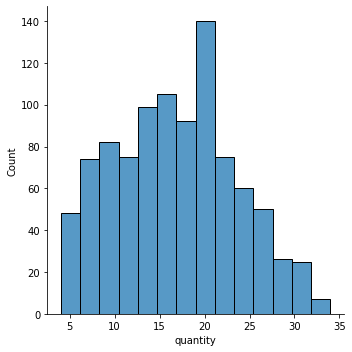

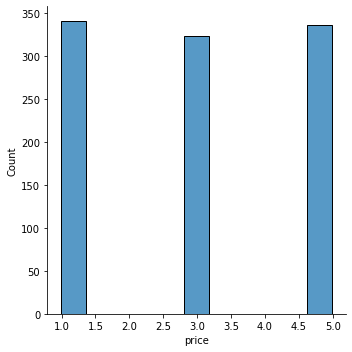

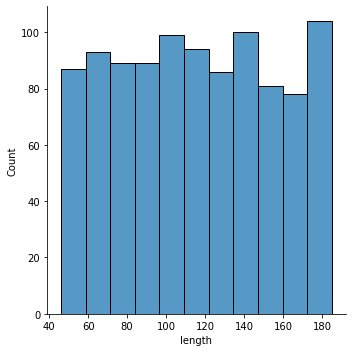

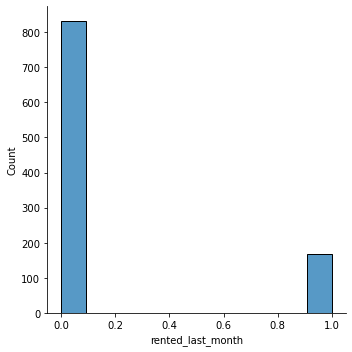

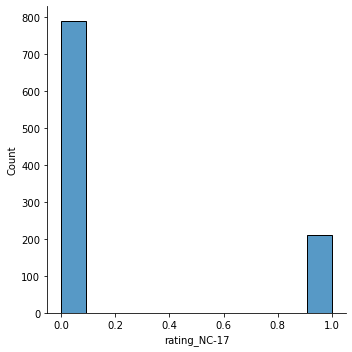

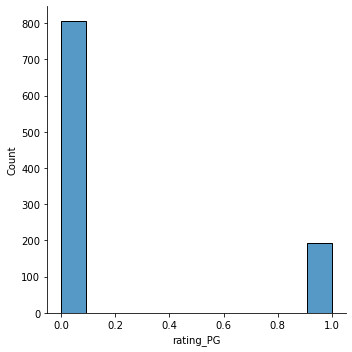

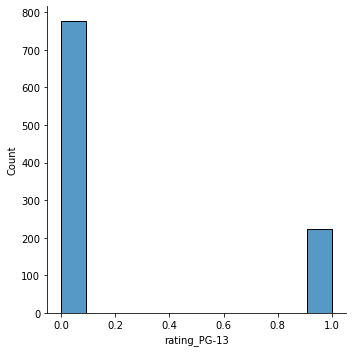

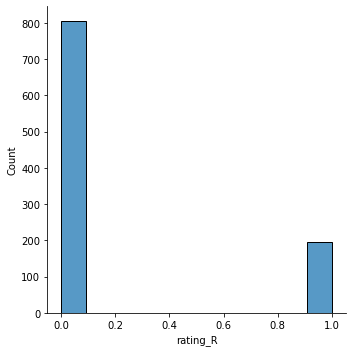

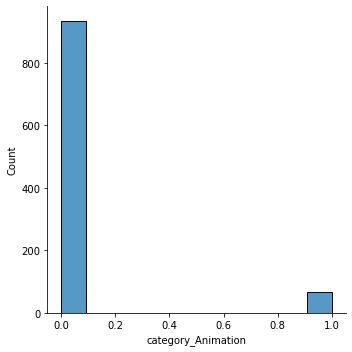

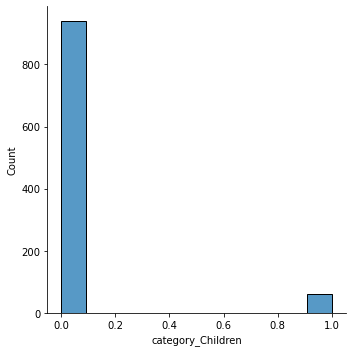

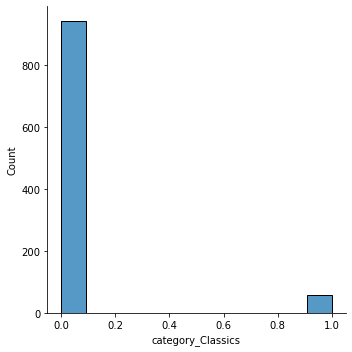

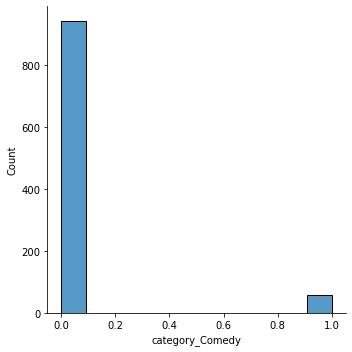

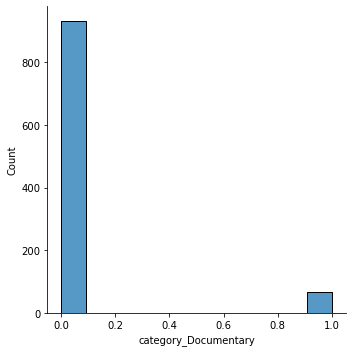

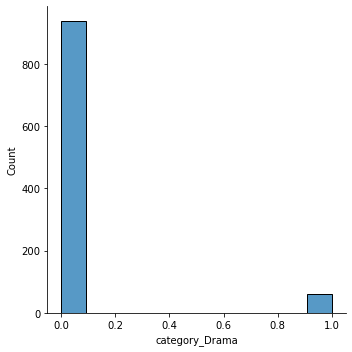

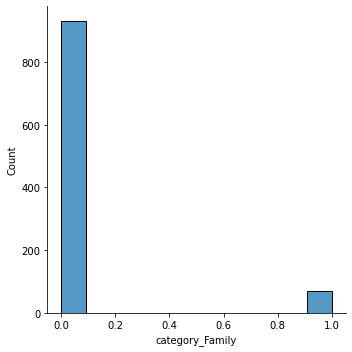

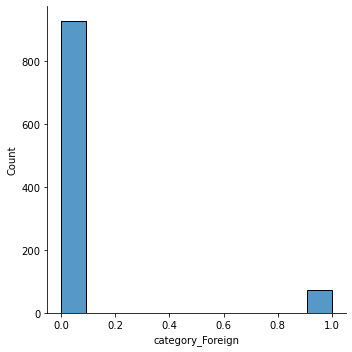

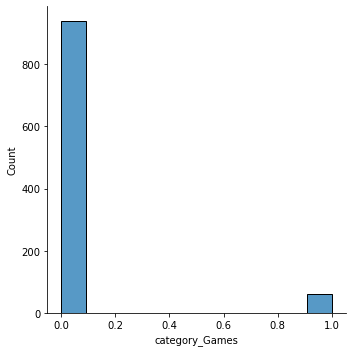

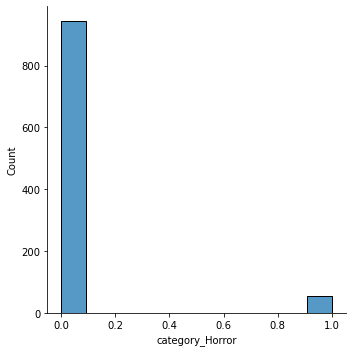

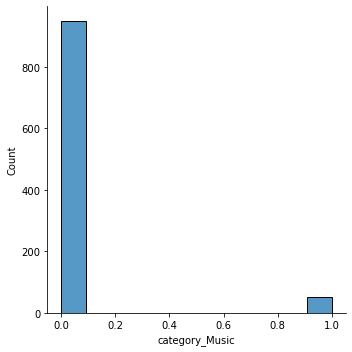

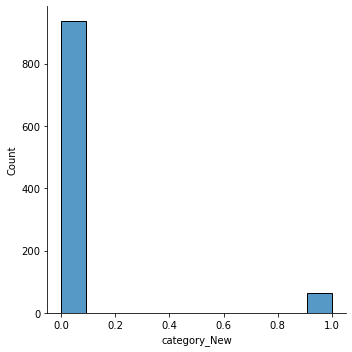

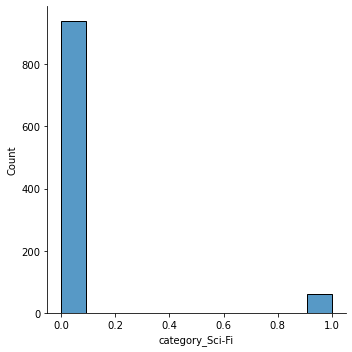

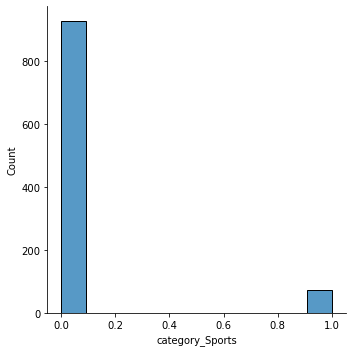

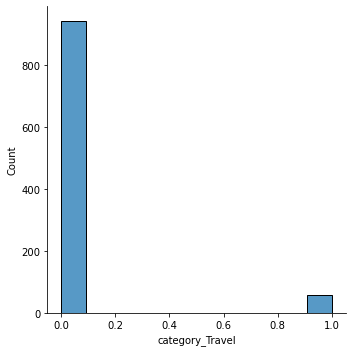

In [99]:
for col in df2.select_dtypes(np.number):
    sns.displot(df2[col])
    plt.show()

In [100]:
df2=df2.dropna()


In [101]:
df2['film_id'] = df2['film_id'].astype('object') # treating duration as categorical
df2['quantity'] = df2['quantity'].astype('int64') # treating duration as categorical
df2['price'] = df2['price'].astype('int64') # treating duration as categorical

df2.dtypes

<ipython-input-101-4bf40d19f7ad>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['film_id'] = df2['film_id'].astype('object') # treating duration as categorical
<ipython-input-101-4bf40d19f7ad>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['quantity'] = df2['quantity'].astype('int64') # treating duration as categorical
<ipython-input-101-4bf40d19f7ad>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

film_id                 object
quantity                 int64
price                    int64
length                   int64
rented_last_month        int64
rating_NC-17             uint8
rating_PG                uint8
rating_PG-13             uint8
rating_R                 uint8
category_Animation       uint8
category_Children        uint8
category_Classics        uint8
category_Comedy          uint8
category_Documentary     uint8
category_Drama           uint8
category_Family          uint8
category_Foreign         uint8
category_Games           uint8
category_Horror          uint8
category_Music           uint8
category_New             uint8
category_Sci-Fi          uint8
category_Sports          uint8
category_Travel          uint8
dtype: object

In [102]:
df2.set_index('film_id')
df2

,film_id,quantity,price,length,rented_last_month,rating_NC-17,rating_PG,rating_PG-13,rating_R,category_Animation,...,category_Drama,category_Family,category_Foreign,category_Games,category_Horror,category_Music,category_New,category_Sci-Fi,category_Sports,category_Travel
0,489,32,0,54,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1,730,32,0,46,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2,127,30,4,112,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,341,30,0,82,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,403,30,4,121,1,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
953,781,5,4,127,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
954,903,5,4,139,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
955,400,4,2,72,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
956,584,4,2,180,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0


In [103]:
y = df2['rented_last_month']
X = df2.drop(['rented_last_month', 'film_id'], axis=1)

In [104]:
X = pd.get_dummies(X)
X

,quantity,price,length,rating_NC-17,rating_PG,rating_PG-13,rating_R,category_Animation,category_Children,category_Classics,...,category_Drama,category_Family,category_Foreign,category_Games,category_Horror,category_Music,category_New,category_Sci-Fi,category_Sports,category_Travel
0,32,0,54,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,32,0,46,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,30,4,112,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,30,0,82,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,30,4,121,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
953,5,4,127,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
954,5,4,139,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
955,4,2,72,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
956,4,2,180,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [106]:
classification = LogisticRegression(random_state=42, multi_class='multinomial', max_iter=500) # max_iter
classification.fit(X_train, y_train)

LogisticRegression(max_iter=500, multi_class='multinomial', random_state=42)

### 6- Evaluate the results (calculate the score of the model)

In [107]:
classification.score(X_test, y_test)


0.8489583333333334

In [109]:
predictions = classification.predict(X_test)
pd.Series(predictions).value_counts()


0    192
dtype: int64

In [110]:
y_test.value_counts()


0    163
1     29
Name: rented_last_month, dtype: int64

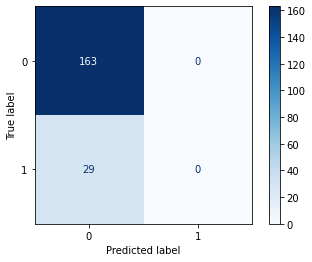

In [113]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(classification, X_test, y_test, cmap='Blues')
plt.show()